In [164]:
#for more advanced mapfile operations: https://github.com/Deltares/dfm_tools/blob/main/tests/examples/postprocess_mapnc_ugrid.py

import json
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import dfm_tools as dfmt
import pandas as pd
import os

### Post processing for map outputs Delft3D FM (MapFormat = 4)
This notebook displays :
- the grid of the model
- the bed level of the model
- the external forcings at a given time (wind/air temperature/cloud coverage)
- the water level at a given time
- the water velocity at a given time and depth
- the water temperature at a given time and depth
- the water temperature on a transect at a given time

It uses the **dfm_tools** package developed by Deltares (https://github.com/Deltares/dfm_tools)

**Interesting variables :**
mesh2d_flowelem_bl = bed level
mesh2d_s1 = water level
mesh2d_ucx = Flow element center velocity vector, x-component




# Set config variables

In [165]:
#set paths and parameters per model
#the necessary data is automatically downloaded from opendap if needed
model = 'lugano_1y_10part_corr_thick'
time_plot = 150

In [166]:
with open('config_plots.json', 'r') as file:
    config_plots = json.load(file)[model]
    
file_nc_map = config_plots['file_nc_map']
sel_slice_x = slice(config_plots['sel_slice_x'][0],config_plots['sel_slice_x'][1])
sel_slice_y = slice(config_plots['sel_slice_y'][0],config_plots['sel_slice_y'][1])
crs = config_plots['crs']
raster_res = config_plots['raster_res']
umag_clim = config_plots['umag_clim']
scale = config_plots['scale']
line_array = np.array(config_plots['line_array'])    

In [167]:
if 'partition_number' in config_plots:
    output_dir = config_plots['working_dir']
    n_part = config_plots['partition_number']
    file_nc_map = []
    for n in range(n_part):
        file_nc_map.append(os.path.join(output_dir, f'FlowFM_{n:04}_map.nc'))

# Get data

In [168]:
#open+merge mapfile with xugrid(xarray) and print netcdf structure
uds_map = dfmt.open_partitioned_dataset(file_nc_map)
time_plot_str = pd.to_datetime(uds_map["time"].values[time_plot]).strftime('%Y-%m-%d %H:%M')

>> xu.open_dataset() with 10 partition(s): 1 2 3 4 5 6 7 8 9 10 : 3.59 sec
>> xu.merge_partitions() with 10 partition(s): 1.98 sec
>> dfmt.open_partitioned_dataset() total: 5.57 sec


# Plot grid and bed level

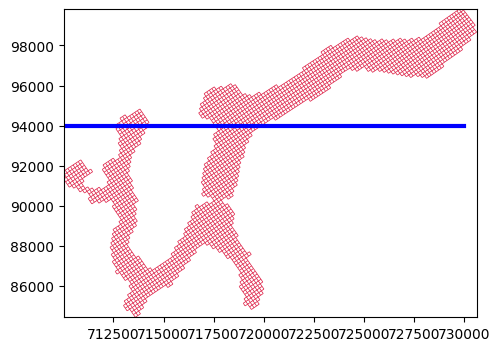

In [169]:
#plot net/grid. use random variable and plot line to get grid
fig, ax = plt.subplots(figsize=(10,4))
pc = uds_map.grid.plot(edgecolor='crimson', linewidth=0.5)
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
if line_array is not None:
    ax.plot(line_array[:,0],line_array[:,1],'b',linewidth=3)


>> rasterizing ugrid Dataset with 1 face variables to shape=(154,206): 0.54 sec


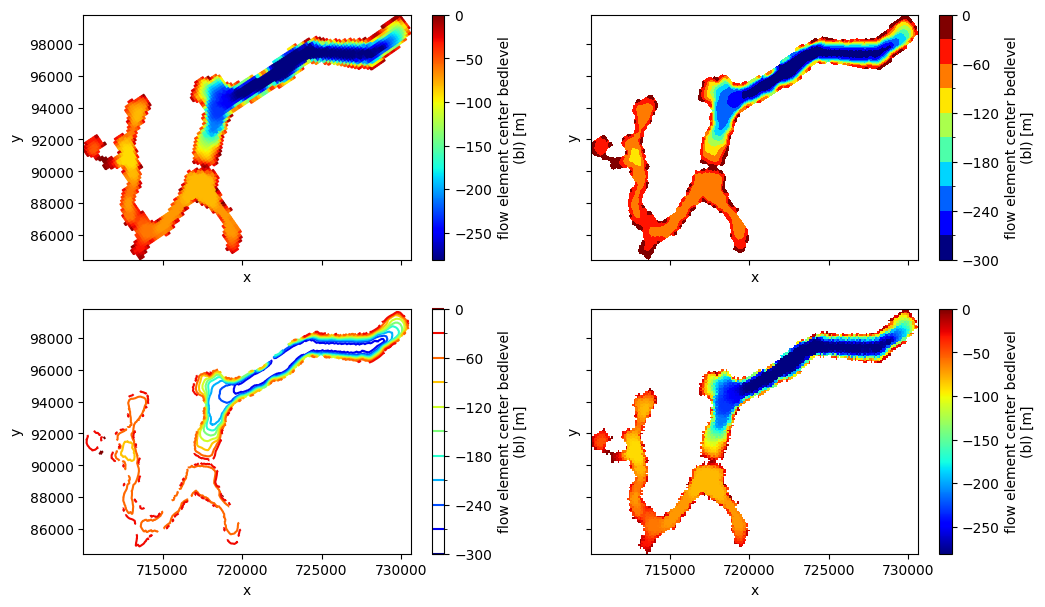

In [170]:
#plot bedlevel on map, including contour/contourf/rasterized
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,7),sharex=True,sharey=True)
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot(ax=ax1, cmap='jet')
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot.contourf(ax=ax2, levels=11, cmap='jet')
pc = uds_map['mesh2d_flowelem_bl'].ugrid.plot.contour(ax=ax3, levels=11, cmap='jet', add_colorbar=True)
bl_raster = dfmt.rasterize_ugrid(uds_map[['mesh2d_flowelem_bl']],resolution=raster_res) #rasterize ugrid
pc = bl_raster['mesh2d_flowelem_bl'].plot(ax=ax4, cmap='jet') #plot with non-ugrid method
for ax in (ax1,ax2,ax3,ax4):
    if crs is None:
        ax.set_aspect('equal')
    else:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


# Plot external forcing

In [171]:
#plot external forcing on map, including windx/windy/air temperature
var1 = 'mesh2d_windx'
var2 = 'mesh2d_windy'
var3 = 'mesh2d_Tair'
var4 = 'mesh2d_Clou'

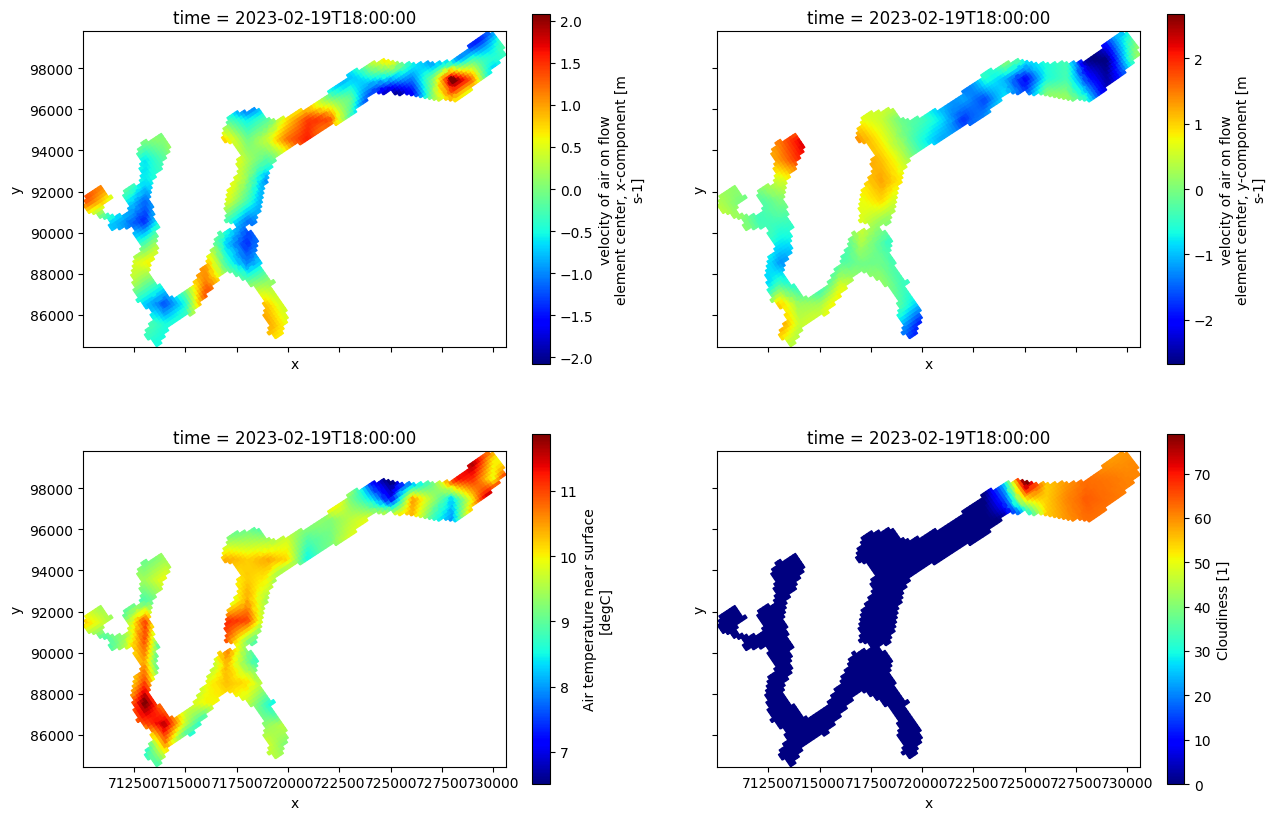

In [172]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10),sharex=True,sharey=True)
pc = uds_map.isel(time=time_plot)[var1].ugrid.plot(ax=ax1, cmap='jet')
pc = uds_map.isel(time=time_plot)[var2].ugrid.plot(ax=ax2, cmap='jet')
pc = uds_map.isel(time=time_plot)[var3].ugrid.plot(ax=ax3, cmap='jet')
pc = uds_map.isel(time=time_plot)[var4].ugrid.plot(ax=ax4, cmap='jet')
for ax in (ax1,ax2,ax3,ax4):
    if crs is None:
        ax.set_aspect('equal')
    else:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)

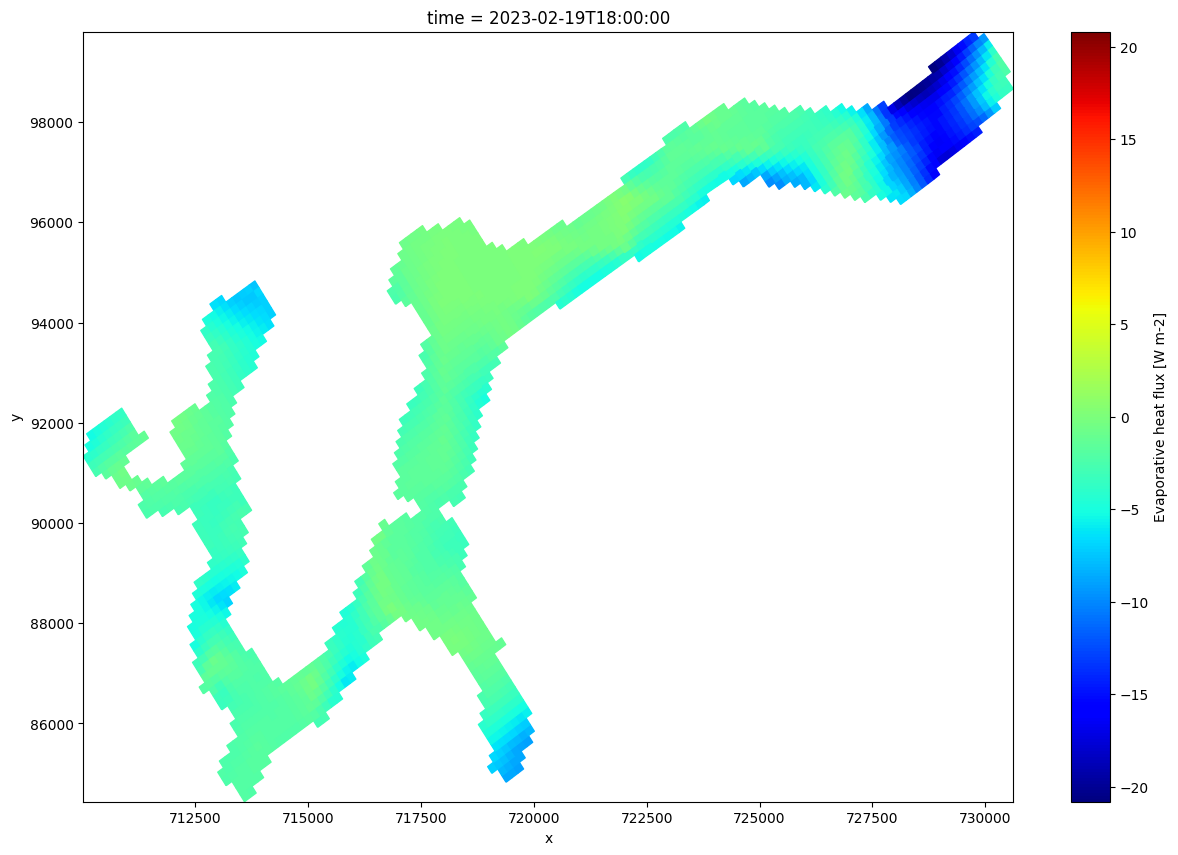

In [173]:
var = 'mesh2d_Qeva'
fig, ax1 = plt.subplots(figsize=(15,10))
pc = uds_map.isel(time=time_plot)[var].ugrid.plot(ax=ax1, cmap='jet')

# Plot water level

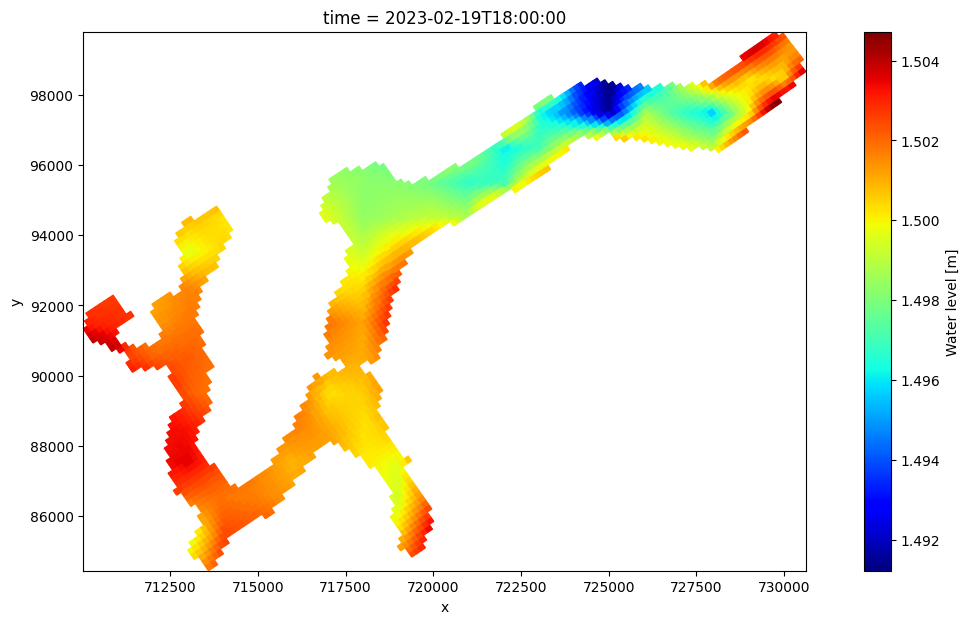

In [174]:
#filter dry cells
bool_drycells = uds_map['mesh2d_s1']==uds_map['mesh2d_flowelem_bl']
uds_map['mesh2d_s1_filt'] = uds_map['mesh2d_s1'].where(~bool_drycells)

#plot water level on map
fig, ax = plt.subplots(figsize=(15,7))
pc = uds_map['mesh2d_s1_filt'].isel(time=time_plot).ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


# Plot velocities

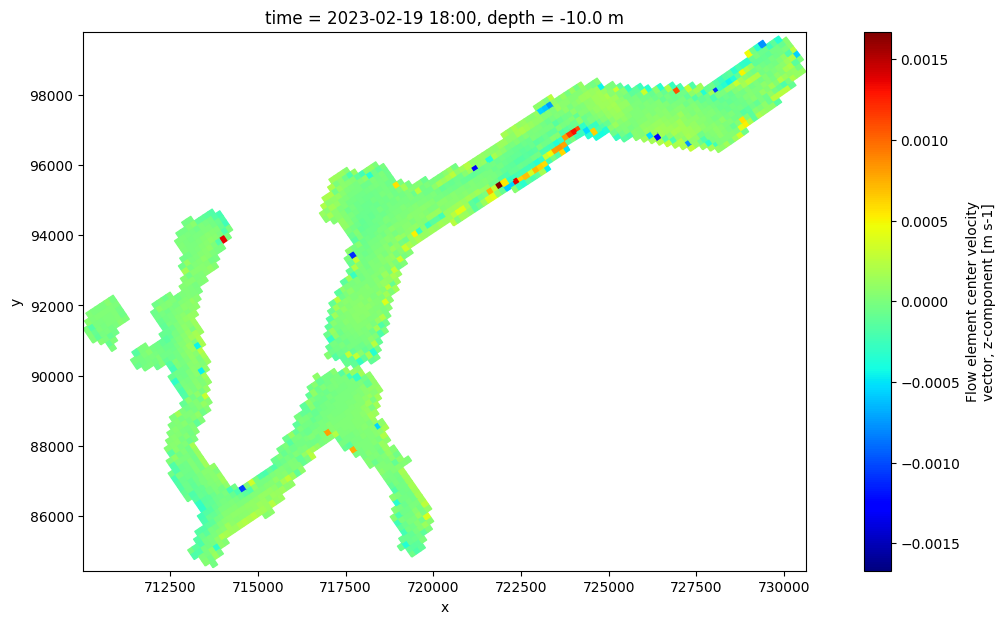

In [175]:
#plot eastward velocities on map, on depth from waterlevel/z0/bedlevel
depth_plot = -10
i_depth_plot = (np.abs(uds_map['mesh2d_layer_z'].values - depth_plot)).argmin()
str_exact_depth_plot = str(round(uds_map["mesh2d_layer_z"].values[i_depth_plot],1))

fig, ax = plt.subplots(figsize=(15,7))
pc = uds_map['mesh2d_ucz'].isel(time=time_plot,mesh2d_nLayers=i_depth_plot).ugrid.plot(cmap='jet')
ax.set_title(rf'time = {time_plot_str}, depth = {str_exact_depth_plot} m')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


>> rasterizing ugrid Dataset with 2 face variables to shape=(154,206): 0.76 sec


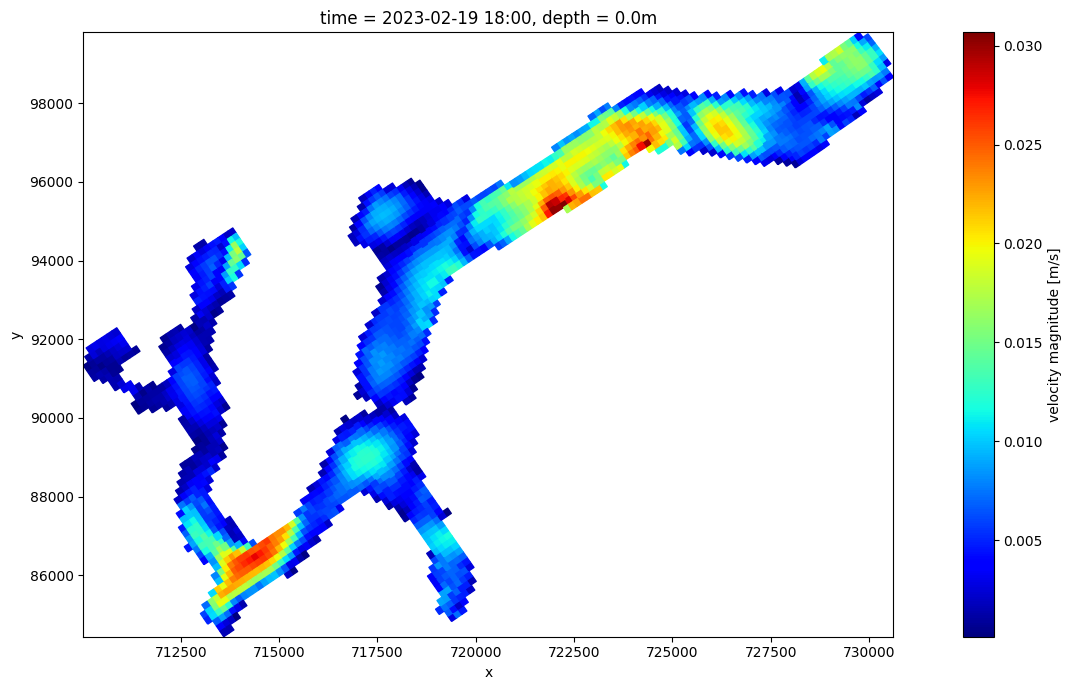

In [176]:
# velocity magnitude and quiver
mesh2d_nLayers = -2 
uds_quiv = uds_map.isel(time=time_plot, mesh2d_nLayers=mesh2d_nLayers,  missing_dims='ignore')
varn_ucx, varn_ucy = 'mesh2d_ucx', 'mesh2d_ucy'
magn_attrs = {'long_name':'velocity magnitude', 'units':'m/s'}
uds_quiv['magn'] = np.sqrt(uds_quiv[varn_ucx]**2+uds_quiv[varn_ucy]**2).assign_attrs(magn_attrs)
raster_quiv = dfmt.rasterize_ugrid(uds_quiv[[varn_ucx,varn_ucy]], resolution=raster_res)

#plot
fig,ax = plt.subplots(figsize=(15,7))
pc = uds_quiv['magn'].ugrid.plot(cmap='jet')
ax.set_title(rf'time = {time_plot_str}, depth = {uds_map["mesh2d_layer_z"].values[mesh2d_nLayers]}m')
#raster_quiv.plot.quiver(x='mesh2d_face_x',y='mesh2d_face_y',u=varn_ucx,v=varn_ucy,color='w',scale=scale,add_guide=False)
pc.set_clim(umag_clim)
fig.tight_layout()
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


# Plot temperature

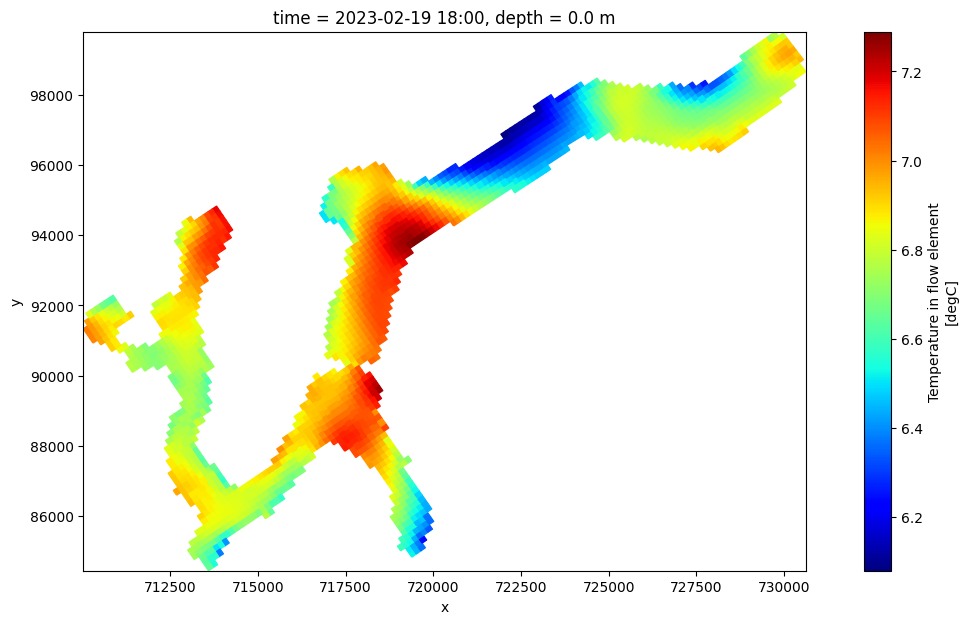

In [177]:
#plot temperature on map, on depth from waterlevel/z0/bedlevel
depth_plot = -0
i_depth_plot = (np.abs(uds_map['mesh2d_layer_z'].values - depth_plot)).argmin()
str_exact_depth_plot = str(round(uds_map["mesh2d_layer_z"].values[i_depth_plot],1))

fig, ax = plt.subplots(figsize=(15,7))
pc = uds_map['mesh2d_tem1'].isel(time=time_plot,mesh2d_nLayers=i_depth_plot).ugrid.plot(cmap='jet')
ax.set_title(rf'time = {time_plot_str}, depth = {str_exact_depth_plot} m')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


z-layer model, computing zw/zcc (fullgrid) values and treat as fullgrid model from here


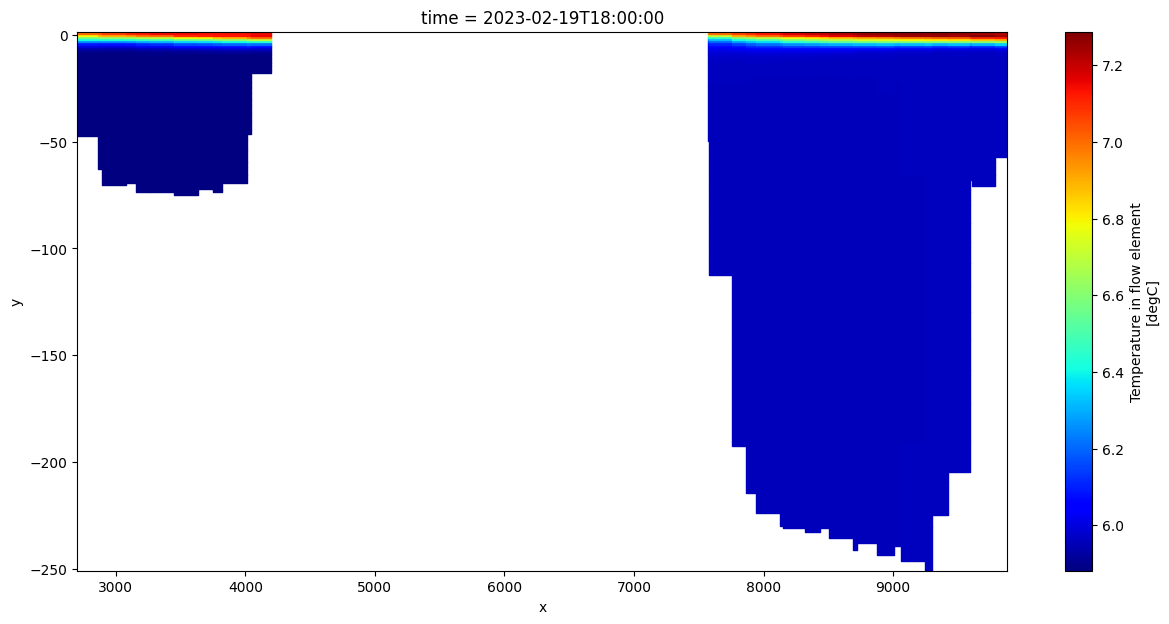

In [178]:
#plot slice/sideview trough 3D temperature mapdata
if line_array is not None:
    uds_crs = dfmt.polyline_mapslice(uds_map.isel(time=time_plot), line_array)
    fig, ax = plt.subplots(figsize=(15,7))
    uds_crs['mesh2d_tem1'].ugrid.plot(cmap='jet')


In [179]:
uds_map

<xarray.Dataset> Size: 6GB
Dimensions:                      (time: 356, mesh2d_nNodes: 2440,
                                  mesh2d_nFaces: 2087, mesh2d_nInterfaces: 47,
                                  mesh2d_nLayers: 46,
                                  mesh2d_nMax_face_nodes: 4, mesh2d_nEdges: 4526)
Coordinates:
  * time                         (time) datetime64[ns] 3kB 2023-02-01 ... 202...
    mesh2d_node_x                (mesh2d_nNodes) float64 20kB dask.array<chunksize=(288,), meta=np.ndarray>
    mesh2d_node_y                (mesh2d_nNodes) float64 20kB dask.array<chunksize=(288,), meta=np.ndarray>
    mesh2d_face_y                (mesh2d_nFaces) float64 17kB dask.array<chunksize=(208,), meta=np.ndarray>
    mesh2d_face_x                (mesh2d_nFaces) float64 17kB dask.array<chunksize=(208,), meta=np.ndarray>
    mesh2d_layer_z               (mesh2d_nLayers) float64 368B -280.3 ... 1.0
    mesh2d_interface_z           (mesh2d_nInterfaces) float64 376B -281.0 ......
    mesh2d_edge_y                (mesh2d_nEdges) float64 36kB dask.array<chunksize=(495,), meta=np.ndarray>
    mesh2d_edge_x                (mesh2d_nEdges) float64 36kB dask.array<chunksize=(495,), meta=np.ndarray>
  * mesh2d_nNodes                (mesh2d_nNodes) int64 20kB 0 1 2 ... 2438 2439
  * mesh2d_nFaces                (mesh2d_nFaces) int64 17kB 0 1 2 ... 2085 2086
  * mesh2d_nEdges                (mesh2d_nEdges) int64 36kB 0 1 2 ... 4524 4525
Dimensions without coordinates: mesh2d_nInterfaces, mesh2d_nLayers,
                                mesh2d_nMax_face_nodes
Data variables: (12/53)
    projected_coordinate_system  int32 4B ...
    timestep                     (time) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    mesh2d_node_z                (mesh2d_nNodes) float64 20kB dask.array<chunksize=(288,), meta=np.ndarray>
    mesh2d_ww1                   (time, mesh2d_nFaces, mesh2d_nInterfaces) float64 279MB dask.array<chunksize=(1, 208, 47), meta=np.ndarray>
    mesh2d_flowelem_domain       (mesh2d_nFaces) float64 17kB dask.array<chunksize=(208,), meta=np.ndarray>
    mesh2d_flowelem_globalnr     (mesh2d_nFaces) float64 17kB dask.array<chunksize=(208,), meta=np.ndarray>
    ...                           ...
    mesh2d_u1                    (time, mesh2d_nEdges, mesh2d_nLayers) float64 593MB dask.array<chunksize=(1, 495, 46), meta=np.ndarray>
    mesh2d_czu                   (time, mesh2d_nEdges) float64 13MB dask.array<chunksize=(1, 495), meta=np.ndarray>
    mesh2d_windyu                (time, mesh2d_nEdges) float64 13MB dask.array<chunksize=(1, 495), meta=np.ndarray>
    mesh2d_cfu                   (time, mesh2d_nEdges) float64 13MB dask.array<chunksize=(1, 495), meta=np.ndarray>
    mesh2d_diu                   (time, mesh2d_nEdges, mesh2d_nLayers) float64 593MB dask.array<chunksize=(1, 495, 46), meta=np.ndarray>
    mesh2d_s1_filt               (time, mesh2d_nFaces) float64 6MB dask.array<chunksize=(1, 208), meta=np.ndarray>

# Reference code
Can be useful but isn't used for the basic plots

### To plot a map using the index of the depth (layer) instead of the depth itself

#plot eastward velocities on map, on layer
fig, ax = plt.subplots(figsize=(15,7))
layer=-1
pc = uds_map['mesh2d_ucx'].isel(time=time_plot,mesh2d_nLayers=layer,nmesh2d_layer=layer,missing_dims='ignore').ugrid.plot(cmap='jet')
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)


### coordinate conversion
if crs == 'EPSG:28992':
    to_crs = 'EPSG:4326'
elif crs == 'EPSG:4326':
    to_crs = 'EPSG:28992'
if crs is not None:
    uds_map.ugrid.set_crs(crs)
    uds_map_conv = uds_map.ugrid.to_crs(to_crs)
    fig, ax = plt.subplots()
    uds_map_conv["mesh2d_waterdepth"].isel(time=0).ugrid.plot(ax=ax)
    ctx.add_basemap(ax=ax, source=None, crs=to_crs, attribution=False)


v1max = float(uds_map[var1].max().values)
v1min = float(uds_map[var1].min().values)
v2max = float(uds_map[var2].max().values)
v2min = float(uds_map[var2].min().values)
v3max = float(uds_map[var3].max().values)
v3min = float(uds_map[var3].min().values)
v4max = float(uds_map[var4].max().values)
v4min = float(uds_map[var4].min().values)

#!! VIDEO !! (takes time)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,7),sharex=True,sharey=True)
pc = uds_map.isel(time=0)[var1].ugrid.plot(ax=ax1, cmap='jet', vmin=v1min, vmax=v1max)
pc = uds_map.isel(time=0)[var2].ugrid.plot(ax=ax2, cmap='jet', vmin=v2min, vmax=v2max)
pc = uds_map.isel(time=0)[var3].ugrid.plot(ax=ax3, cmap='jet', vmin=v3min, vmax=v3max)
pc = uds_map.isel(time=0)[var4].ugrid.plot(ax=ax4, cmap='jet', vmin=v4min, vmax=v4max)
for ax in (ax1,ax2,ax3,ax4):
    if crs is None:
        ax.set_aspect('equal')
    else:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
        
def plot_external_forcings(time) :
    pc1 = uds_map.isel(time=time)[var1].ugrid.plot(ax=ax1, cmap='jet', add_colorbar=False, vmin=v1min, vmax=v1max)
    pc2 = uds_map.isel(time=time)[var2].ugrid.plot(ax=ax2, cmap='jet', add_colorbar=False, vmin=v2min, vmax=v2max)
    pc3 = uds_map.isel(time=time)[var3].ugrid.plot(ax=ax3, cmap='jet', add_colorbar=False, vmin=v3min, vmax=v3max)
    pc4 = uds_map.isel(time=time)[var4].ugrid.plot(ax=ax4, cmap='jet', add_colorbar=False, vmin=v4min, vmax=v4max)
    for ax in (ax1,ax2,ax3,ax4):
        if crs is None:
            ax.set_aspect('equal')
        else:
            ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
    return pc1, pc2, pc3, pc4

ani = FuncAnimation(fig, plot_external_forcings, frames=len(uds_map['time']), blit=True)
ani.save(working_dir+r'\output\external_forcing.gif', fps=5, writer='pillow')

#!! VIDEO !! (takes time)
vtempmin = +999
vtempmax = -999
for i in range(len(uds_map['time'])-1):
    values = dfmt.get_Dataset_atdepths(data_xr=uds_map.isel(time=i), depths=-5, reference='waterlevel') 
    min_temp = float(values['mesh2d_tem1'].min().values)
    max_temp = float(values['mesh2d_tem1'].max().values)
    if min_temp < vtempmin:
        vtempmin = min_temp
    if max_temp > vtempmax:
        vtempmax = max_temp

uds_map_atdepths = dfmt.get_Dataset_atdepths(data_xr=uds_map.isel(time=0), depths=-5, reference='waterlevel')
fig, ax = plt.subplots(figsize=(15,7))
pc = uds_map_atdepths['mesh2d_tem1'].ugrid.plot(cmap='jet', vmin=vtempmin, vmax=vtempmax)
if crs is None:
    ax.set_aspect('equal')
else:
    ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
        
def plot_surface_temp(time) :
    uds_map_atdepths = dfmt.get_Dataset_atdepths(data_xr=uds_map.isel(time=time), depths=-5, reference='waterlevel')
    ax = uds_map_atdepths['mesh2d_tem1'].ugrid.plot(cmap='jet', add_colorbar=False, vmin=vtempmin, vmax=vtempmax)
    if crs is None:
        ax.set_aspect('equal')
    else:
        ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs=crs, attribution=False)
    return ax

#ani = FuncAnimation(fig, plot_surface_temp, frames=10, blit=True)
#ani.save(working_dir+r'\output\surface_temp.gif', fps=5, writer='pillow')